In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score
from matplotlib import pyplot as plt
from nn.nn import NeuralNetwork
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs

In [2]:
# Load dataset
positive = read_text_file('data/rap1-lieb-positives.txt')
negative = read_fasta_file('data/yeast-upstream-1k-negative.fa')

### Sampling scheme

In [3]:
# Process negative sequences to be the same length as the positives

def splitseq(seq, step=6, window=17):
    # Split sequences into (window)-mers with a sliding step size
    processed = []
    i = 0
    while i + window <= len(seq):
        processed.append(seq[i:i+window])
        i += step
    return processed

# Try different step sizes: 1, 3, 6, 17
processed_1, processed_3, processed_6, processed_17 = [], [], [], []
for seq in negative:
    processed_1 += splitseq(seq, step=1)
    processed_3 += splitseq(seq, step=3)
    processed_6 += splitseq(seq, step=6)
    processed_17 += splitseq(seq, step=17)
    
# Assess redundancy of 17-mers and overlap with known positive motifs
u1, c1 = np.unique(processed_1, return_counts=True)
u3, c3 = np.unique(processed_3, return_counts=True)
u6, c6 = np.unique(processed_6, return_counts=True)
u17, c17 = np.unique(processed_17, return_counts=True)

What proportion of 17-mers are completely unique?
step 1: 0.9722405080398167
step 3: 0.9850764698793039
step 6: 0.9876405090867623
step 17: 0.9896711484066667


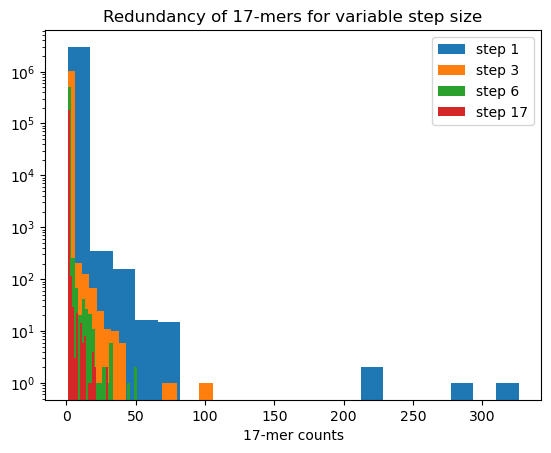

In [4]:
plt.hist(c1, bins=20, log=True, label='step 1')
plt.hist(c3, bins=20, log=True, label='step 3')
plt.hist(c6, bins=20, log=True, label='step 6')
plt.hist(c17, bins=20, log=True, label='step 17')
plt.title('Redundancy of 17-mers for variable step size')
plt.xlabel('17-mer counts')
plt.legend()

print("What proportion of 17-mers are completely unique?")
print('step 1:', np.where(c1==1, 1, 0).mean())
print('step 3:', np.where(c3==1, 1, 0).mean())
print('step 6:', np.where(c6==1, 1, 0).mean())
print('step 17:', np.where(c17==1, 1, 0).mean())

How many positives are in each set of 17-mers?
step 1: 67
step 3: 27
step 6: 15
step 17: 2


Text(0.5, 1.0, 'Which positives appear most often in the sets of 17-mers')

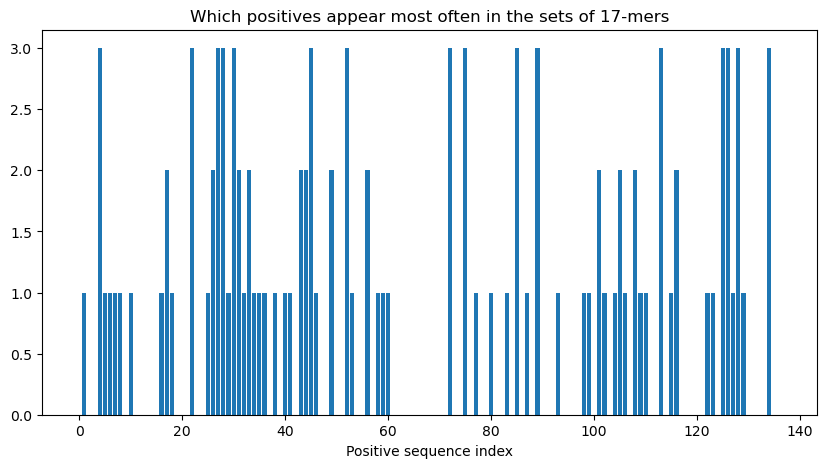

In [5]:
print('How many positives are in each set of 17-mers?')
plt.figure(figsize=(10,5))
overlap = np.where(np.isin(positive, u1), 1, 0)
total_overlap = overlap
print('step 1:', np.sum(overlap))
overlap = np.where(np.isin(positive, u3), 1, 0)
total_overlap += overlap
print('step 3:', np.sum(overlap))
overlap = np.where(np.isin(positive, u6), 1, 0)
total_overlap += overlap
print('step 6:', np.sum(overlap))
overlap = np.where(np.isin(positive, u17), 1, 0)
total_overlap += overlap
print('step 17:', np.sum(overlap))
plt.bar(range(len(positive)),total_overlap)
plt.xlabel('Positive sequence index')
plt.title('Which positives appear most often in the sets of 17-mers')

The negative sequences are processed to be the same size as the positive sequences using a 17-mer sliding window of variable step size. Exploration of the negative sequences reveals that their constitutive 17-mers have low redundancy, with the proportion of completely unique 17-mers increasing slightly as the sliding window step size increases (97% to 99%).

Comparing the "negative" 17-mer sets and positive sequences also reveals significant overlap. Nearly half of the 137 positive sequences overlap with the set of negative 17-mers with a sliding window step size of 1. This overlap drops to <2% for the set of negative 17-mers with a sliding window step size of 17. This suggests that independent 17-mer motifs are insufficient for capturing the binding specificity of transcription factor Rap1. Although a sliding window step size of 17 generates a 17-mer set with the fewest pseudo-false negatives, it is also less representative of the "grammar" of the negative sequences, where grammar is defined as positional interdependencies or broader sequence context that may be important for Rap1 binding specificity. Thus, the negative 17-mer set with sliding window step size of 6 is selected instead, and the pseudo-false negatives in this set are removed. Furthermore, some positive sequences overlap with negative 17-mer sets more than others, implying that they may be less informative for learning binding specificity. These positive sequences will be weighted against during sampling with replacement to generate balanced classes.

In [6]:
# Remove pseudo-false negatives
u6_negative_only = u6[~np.isin(u6, positive)]
# The biggest concern for the model is overfitting on positive sequences.
# Set aside 7 positives (out of 137) that the model will never see.
positive_test = positive[:7]
positive = positive[7:]
total_overlap = total_overlap[7:]
# Also set aside 50 negatives that the model will never see.
negative_test_idx = np.random.choice(range(len(u6_negative_only)), 50, replace=False)
negative_test = u6_negative_only[negative_test_idx]
u6_negative_only = np.delete(u6_negative_only, negative_test_idx)

# Increase the probability of sampling positive sequences that lack
# overlap with negative 17-mer sets proportional to their degree of lack
positive_weighted = []
for s, n in zip(positive, total_overlap):
    # Not the most systematic/statistically-sound way of weighting,
    # but 0-overlap positive sequences will appear 4x more, 
    # 1-overlap positives will appear 3x more, and so on.
    positive_weighted += [s] * (4-n)
seqs = np.concatenate((positive_weighted, u6_negative_only))
labels = np.concatenate((np.ones(len(positive_weighted)), np.zeros(len(u6_negative_only))))

In [7]:
# Balance classes
sampled_seqs, sampled_labels = sample_seqs(seqs, labels)
# One-hot encode data
X = one_hot_encode_seqs(sampled_seqs)

In [8]:
# Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, sampled_labels, test_size=0.2, random_state=42)

### Model training and validation accuracy

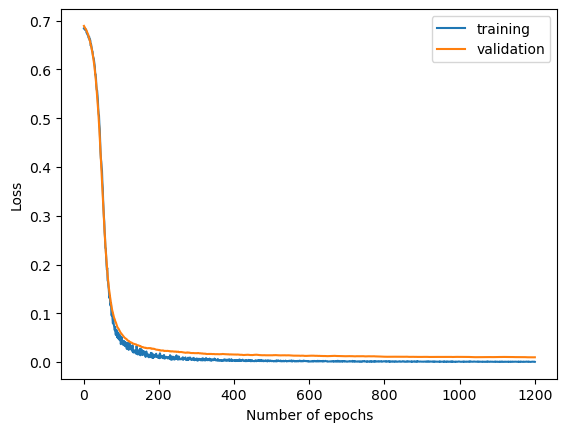

In [9]:
nn_arch = [{'input_dim': 17*4, 'output_dim': 17*2, 'activation': 'relu'}, 
           {'input_dim': 17*2, 'output_dim': 17, 'activation': 'relu'},
           {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}]
lr = 1e-01
seed = 42
batch_size = 200
epochs = 1200
loss_function = 'bce' # since model is a binary classifier

# Generate classifier. 
model = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)
# Train on dataset
loss_train, loss_val = model.fit(X_train, y_train, X_val, y_val)

plt.plot(np.arange(epochs)+1, loss_train, label='training')
plt.plot(np.arange(epochs)+1, loss_val, label='validation')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

In [10]:
# Validation accuracy
y_hat = model.predict(X_val)
y_binary = np.where(y_hat <= 0.5, 0, 1)
print('ROC AUC:', roc_auc_score(y_val, y_binary))
print('Accuracy:', accuracy_score(y_val, y_binary))
print('F1:', f1_score(y_val, y_binary))

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0


### Hyperparameter testing

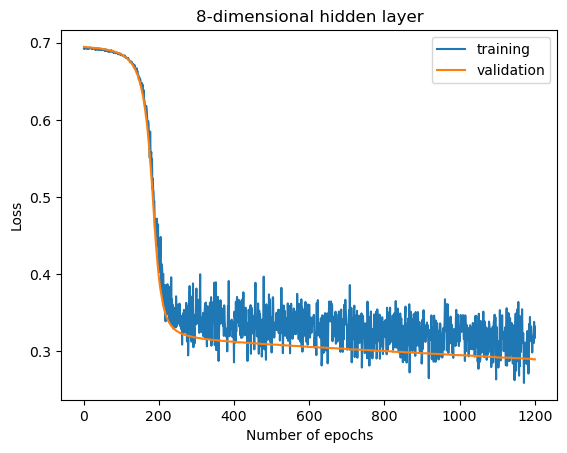

In [11]:
nn_arch = [{'input_dim': 17*4, 'output_dim': 17*2, 'activation': 'relu'}, 
           {'input_dim': 17*2, 'output_dim': 17, 'activation': 'relu'},
           {'input_dim': 17, 'output_dim': 8, 'activation': 'relu'},
           {'input_dim': 8, 'output_dim': 1, 'activation': 'sigmoid'}]
lr = 1e-01
seed = 42
batch_size = 200
epochs = 1200
loss_function = 'bce'

# Generate classifier. 
model = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)
# Train on dataset
loss_train, loss_val = model.fit(X_train, y_train, X_val, y_val)

plt.plot(np.arange(epochs)+1, loss_train, label='training')
plt.plot(np.arange(epochs)+1, loss_val, label='validation')
plt.title('8-dimensional hidden layer')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

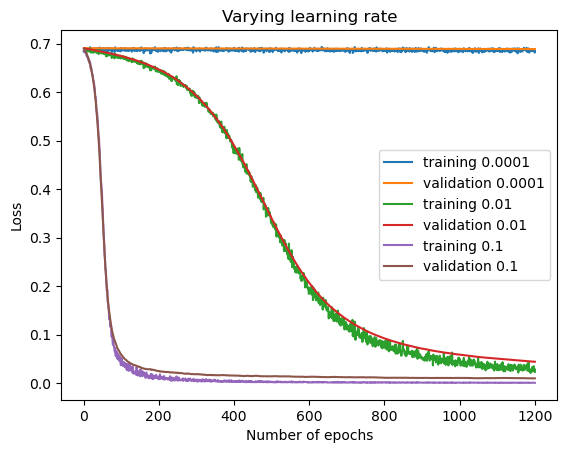

In [12]:
nn_arch = [{'input_dim': 17*4, 'output_dim': 17*2, 'activation': 'relu'}, 
           {'input_dim': 17*2, 'output_dim': 17, 'activation': 'relu'},
           {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}]
lrs = [1e-04, 1e-02, 1e-01]
seed = 42
batch_size = 200
epochs = 1200
loss_function = 'bce'

# Generate classifier. 
for lr in lrs:
    model = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)
    # Train on dataset
    loss_train, loss_val = model.fit(X_train, y_train, X_val, y_val)
    plt.plot(np.arange(epochs)+1, loss_train, label='training ' + str(lr))
    plt.plot(np.arange(epochs)+1, loss_val, label='validation ' + str(lr))
plt.title('Varying learning rate')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

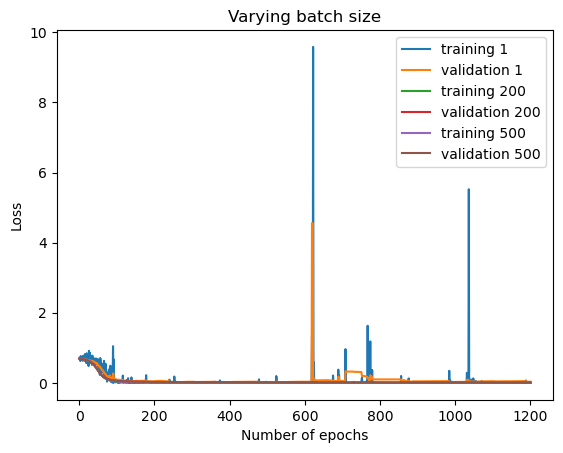

In [13]:
nn_arch = [{'input_dim': 17*4, 'output_dim': 17*2, 'activation': 'relu'}, 
           {'input_dim': 17*2, 'output_dim': 17, 'activation': 'relu'},
           {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}]
lrs = 1e-01
seed = 42
batch_sizes = [1, 200, 500]
epochs = 1200
loss_function = 'bce'

# Generate classifier. 
for batch_size in batch_sizes:
    model = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)
    # Train on dataset
    loss_train, loss_val = model.fit(X_train, y_train, X_val, y_val)
    plt.plot(np.arange(epochs)+1, loss_train, label='training ' + str(batch_size))
    plt.plot(np.arange(epochs)+1, loss_val, label='validation ' + str(batch_size))
plt.title('Varying batch size')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

For a binary classification model, two ReLU-activation hidden layers are used, followed by a sigmoid-activation output layer to return values near zero and near one (negative and positive class prediction, respectively). Because sklearn's scoring functions need binary predictions, values less than or equal to 0.5 (i.e., sigmoid(z=0)) are considered negative class and values greater than 0.5 are considered positive class.

Layer dimensions follow rational reduction from 17 x 4 (17-mer x 4 bits per base) to 17 x 2 (17-mer x AT/GC, though it is not possible to conclude that this is what the model is learning) to 17 (17-mer). Introducing an 8-dimensional hidden layer worsens performance.

A learning rate of 0.1 provides the minimum achievable validation loss in 1200 epochs. A batch size of 200 demonstrates better convergence than stochastic gradient descent (batch size of 1) but shows no significant improvement over a larger batch size of 500, which is more computationally expensive.

### Test the model on positive and negative sequences it has never seen before

Accuracy: 1.0
F1: 1.0


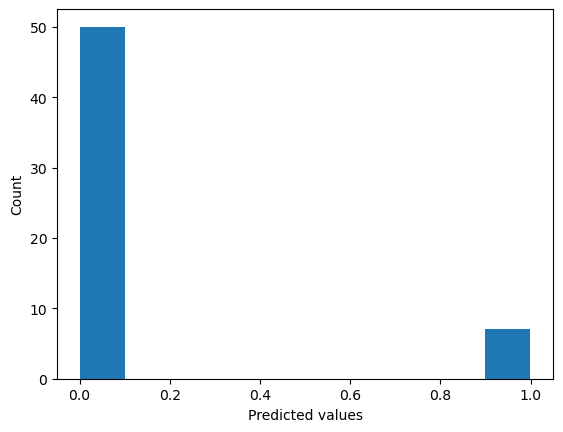

In [14]:
X_test = one_hot_encode_seqs(np.concatenate((positive_test, negative_test)))
y_test = np.concatenate((np.ones(len(positive_test)), np.zeros(len(negative_test))))
y_hat = model.predict(X_test)
plt.hist(y_hat)
plt.xlabel('Predicted values')
plt.ylabel('Count')
y_binary = np.where(y_hat <= 0.5, 0, 1)
print('Accuracy:', accuracy_score(y_test, y_binary))
print('F1:', f1_score(y_test, y_binary))

The model performs very well on positive and negative test sequences it has never seen before. However, these sequences are still drawn from the same datasets used to train the model, so a perfect accuracy score does raise concerns of overfitting.